# Diagnosing the BOLD data, continued

Diagnosing the BOLD data after knocking of the first volume.

We discovered in the [diagnostics](diagnostics.ipynb) notebook that the first volume was very different from the rest in our BOLD dataset.

This notebook fixes the dataset by stripping off the first volume, and then runs diagnostics on the fixed dataset.

In [1]:
%matplotlib inline

We make sure we have some useful libraries loaded:

In [2]:
import os
import numpy as np # array manipulation
import matplotlib.pyplot as plt # plotting library

Set some defaults for plotting:

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

We need the library to load and analyze images:

In [4]:
from nipy import load_image, save_image
from nipy.core.api import Image, drop_io_dim, rollimg
from nipy.algorithms.utils.pca import pca_image
from nipy.algorithms.diagnostics import screens

Get the original image to look at:

In [5]:
subj_dir = 'sub009'

In [6]:
bold_fname = os.path.join(subj_dir, 'BOLD/task002_run001/bold.nii.gz')

In [7]:
img = load_image(bold_fname)
img.shape

(64, 64, 30, 173)

The following command uses the `nipy` image object to slice off the first volume:

In [8]:
fixed_img = img[:, :, :, 1:]
fixed_img.shape

(64, 64, 30, 172)

We save this image for future use:

In [9]:
save_image(fixed_img, 'fixed_bold.nii.gz');

/usr/local/lib/python2.7/dist-packages/nipy/io/files.py:143: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


Try PCA again on the fixed data:

In [10]:
img_pca_results = pca_image(fixed_img, axis='t', ncomp=10)

/usr/local/lib/python2.7/dist-packages/nipy/algorithms/utils/pca.py:143: RuntimeWarning: divide by zero encountered in divide
  return np.where(rmse<=0, 0, 1. / rmse)


The principal components:

In [11]:
img_pca_results['basis_vectors'].shape

(172, 171)

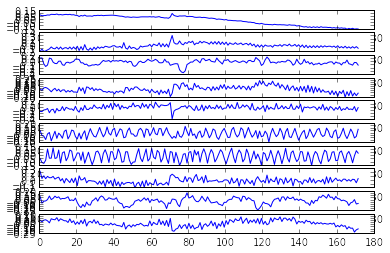

In [12]:
fig, axes = plt.subplots(10, 1)
for i, ax in enumerate(axes):
    ax.plot(img_pca_results['basis_vectors'][:, i])

As you see, the new principal components are much like the old, except the first component has gone, as we expected.

Here's the projection of the new first component:

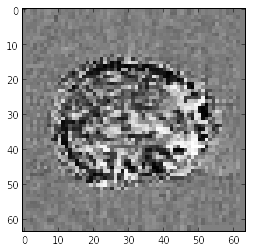

In [13]:
pca0 = img_pca_results['basis_projections']
plt.imshow(pca0.get_data()[:, :, 17, 0])

Now we do some more simple diagnostic checks:

In [14]:
dx = screens.screen(fixed_img, slice_axis=2)

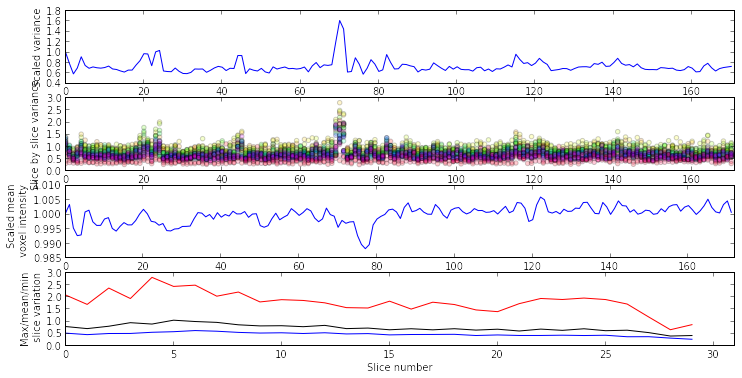

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(12, 6))
screens.plot_tsdiffs(dx['ts_res'], axes);

The third plot in this figure is the simplest.  It is just the mean across all the voxels for each volume, divided by the mean for all voxels in every volume.  Like this:

In [16]:
fixed_data = fixed_img.get_data()
fixed_data.shape

(64, 64, 30, 172)

In [17]:
mean_all_voxels = fixed_data.mean() # mean of all voxels in all volumes
mean_all_voxels

336.48400907294695

In [18]:
scaled_data = fixed_data / mean_all_voxels

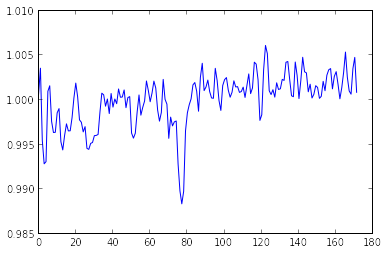

In [19]:
T = scaled_data.shape[3]
mean_per_volume = np.zeros(T)
for i in range(T):
    this_vol = scaled_data[:, :, :, i]
    mean_per_volume[i] = this_vol.mean() # mean of all voxels per volume
plt.plot(mean_per_volume);

This is the same data as for the third panel from the diagnostics plot above (it looks different because of the different scaling of the axes).

The top panel gives a measure of the average difference from one volume to the next.  Like this:

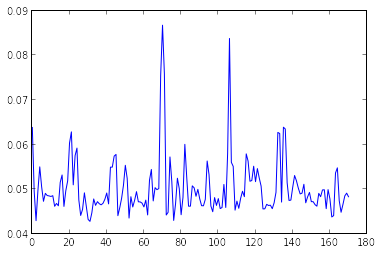

In [20]:
vol_to_vol_differences = np.zeros(T-1)
for i in range(T-1):
    this_vol = scaled_data[:, :, :, i]
    last_vol = scaled_data[:, :, :, i+1]
    difference = this_vol - last_vol
    vol_to_vol_differences[i] = np.sqrt(np.mean(difference ** 2))
plt.plot(vol_to_vol_differences);

Again, this is the same data as the top panel in the diagnostics plot.

See : http://imaging.mrc-cbu.cam.ac.uk/imaging/DataDiagnostics for a more detailed explanation.